In [1]:
!pip install tqdm
!pip install pandas
!pip install --upgrade keras
!pip install kagglehub[pandas-datasets]
!pip install tensorflow-cpu
!pip install matplotlib


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


class ModelCompare:
    def __init__(self, model_instances: list = [], pca_components: int = 2):
        self.models = model_instances
        self.pca_components = pca_components
        self.pca = PCA(n_components=pca_components)


    def fit(self, X, y, *args, **kwargs):
        for model in self.models:
            model.fit(X, y, *args, **kwargs)


    def predict(self, X):
        l = []
        for model in self.models:
            predictions = model.predict(X)
            l.append(np.where(predictions >= 0.5, 1.0, 0.0))

        return l


    # ==========================================================================
    #               *** 2D Plot Using PCA Projection ***
    # ==========================================================================
    def plot(self, X, y, titles=None, max_points=200_000, offset=0.5, step=None):
        if titles is None:
            titles = [""] * len(self.models)

        # PCA-transform data for display
        Xp = self.pca.fit_transform(X)

        # Determine 2D plot bounds from PCA projection
        x_min, x_max = Xp[:, 0].min() - offset, Xp[:, 0].max() + offset
        y_min, y_max = Xp[:, 1].min() - offset, Xp[:, 1].max() + offset

        dx = x_max - x_min
        dy = y_max - y_min

        # Auto-step to limit memory
        if step is None:
            step = np.sqrt((dx * dy) / max_points)

        # Meshgrid in PCA space
        xx, yy = np.meshgrid(
            np.arange(x_min, x_max, step),
            np.arange(y_min, y_max, step)
        )

        grid_pca = np.c_[xx.ravel(), yy.ravel()]

        # Convert PCA grid → ORIGINAL FEATURE SPACE
        grid_full = self.pca.inverse_transform(grid_pca)

        # Model predictions IN FULL SPACE
        preds = []
        for p in self.predict(grid_full):
            preds.append(p.reshape(xx.shape))

        # Plot results
        nrows = (len(self.models) + 1) // 2
        fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(10, 5 * nrows))
        ax = ax.flatten()

        for i, p in enumerate(preds):
            ax[i].contourf(xx, yy, p, alpha=0.3, cmap=plt.cm.Accent)
            ax[i].scatter(Xp[:, 0], Xp[:, 1], c=y, edgecolor='k', cmap=plt.cm.Accent)
            ax[i].set_title(titles[i])

        # Remove unused subplots
        for j in range(i + 1, len(ax)):
            fig.delaxes(ax[j])

        plt.tight_layout()
        plt.show()


# Preparação do dataset

Esse dataset contêm informações sobre penguins como onde eles vivem, sua especie, peso, genero, etc.
Baseado nisso, iremos fazer uma classificação do genero de cada penguim baseado nessa informação.

In [3]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "penguins (1).csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "varishabatool/ecological-traits-of-antarctic-penguins-dataset",
  file_path,
)

df

/home/fabio/Documents/Projects/noobs-on-ai/neural-net/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_5844/205883744.py:8: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


,Unnamed: 0,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,1,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,2,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,3,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,4,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,5,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
...,...,...,...,...,...,...,...,...,...
339,340,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,341,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,342,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,343,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         344 non-null    int64  
 1   species            344 non-null    object 
 2   island             344 non-null    object 
 3   bill_length_mm     342 non-null    float64
 4   bill_depth_mm      342 non-null    float64
 5   flipper_length_mm  342 non-null    float64
 6   body_mass_g        342 non-null    float64
 7   sex                333 non-null    object 
 8   year               344 non-null    int64  
dtypes: float64(4), int64(2), object(3)
memory usage: 24.3+ KB


In [5]:
dropped_columns = ['Unnamed: 0', 'year']
ndf = df.drop(columns=dropped_columns).dropna(subset=['sex'])
ndf

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male
...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male


Lista todas as linhas que contêm uma coluna nula

In [6]:
ndf[ndf.isna().any(axis=1)]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex


In [7]:
from sklearn.preprocessing import LabelEncoder

categorical_columns = ["species", "island", "sex"]
encoder = LabelEncoder()

for col in categorical_columns:
    ndf[col] = encoder.fit_transform(ndf[col])

In [8]:
ndf.describe()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
count,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000
mean,0.918919,0.651652,43.992793,17.164865,200.966967,4207.057057,0.504505
std,0.889718,0.714715,5.468668,1.969235,14.015765,805.215802,0.500732
min,0.000000,0.000000,32.100000,13.100000,172.000000,2700.000000,0.000000
25%,0.000000,0.000000,39.500000,15.600000,190.000000,3550.000000,0.000000
50%,1.000000,1.000000,44.500000,17.300000,197.000000,4050.000000,1.000000
75%,2.000000,1.000000,48.600000,18.700000,213.000000,4775.000000,1.000000
max,2.000000,2.000000,59.600000,21.500000,231.000000,6300.000000,1.000000


In [9]:
import numpy as np

X, y = ndf.iloc[:, 0:6].values, ndf.iloc[:, 6].values

In [10]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()
X_t = scaler.fit_transform(X, y)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_t, y, random_state=69)

# Construindo a Rede

In [50]:
import keras
from keras.layers import Dense, LeakyReLU
from keras.optimizers import Adam


neural_net = keras.Sequential([
    Dense(6, input_shape=(6,)),
    LeakyReLU(),
    Dense(6, input_shape=(6,)),
    LeakyReLU(),
    Dense(6, input_shape=(6,)),
    LeakyReLU(),
    Dense(1, activation='sigmoid', input_shape=(6, ))
])

opt = Adam(learning_rate=0.005)

neural_net.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
neural_net.summary()


/home/fabio/Documents/Projects/noobs-on-ai/neural-net/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 6)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 6)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 6)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133 (532.00 B)

 Trainable params: 133 (532.00 B)

 Non-trainable params: 0 (0.00 B)

In [31]:
from sklearn.svm import SVC

svc = SVC()

# Treinar os modelos

In [51]:
neural_net.fit(X_train, y_train, epochs=150)
svc.fit(X_train, y_train)

Epoch 1/150


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6426 - loss: 0.6393
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6627 - loss: 0.6246
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6827 - loss: 0.6115
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7149 - loss: 0.6006
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7189 - loss: 0.5880
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7269 - loss: 0.5767
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7470 - loss: 0.5654
Epoch 8/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7590 - loss: 0.5539
Epoch 9/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7671 - loss: 0.5426
Epoch 10/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7791 - loss: 0.5304
Epoch 11/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7992 - loss: 0.5189
Epoch 12/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7952 - loss: 0.5075
Ep

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


SVM - Acurácia (manual): 0.857


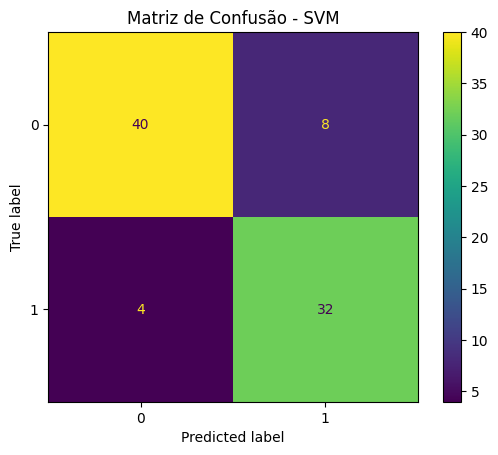

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Neural Net - Acurácia (manual): 0.905


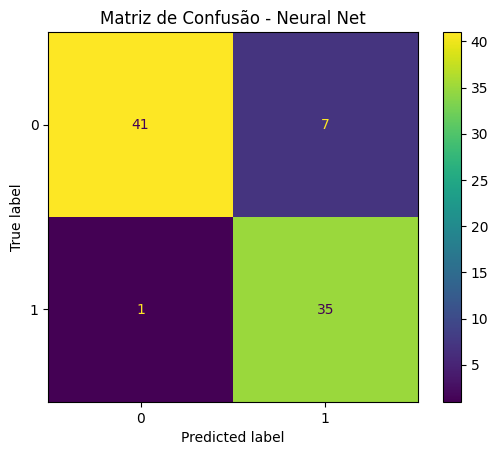

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix

accuracies = {}

for name, model in {'SVM': svc, 'Neural Net': neural_net}.items():
    preds = model.predict(X_test)
    if name == 'Neural Net':
        preds = np.where(preds >= 0.5, 1, 0)

    acc = accuracy_score(y_test, preds)

    print(f"{name} - Acurácia (manual): {acc:.3f}")

    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Matriz de Confusão - {name}")
    plt.show()



6257/6257 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


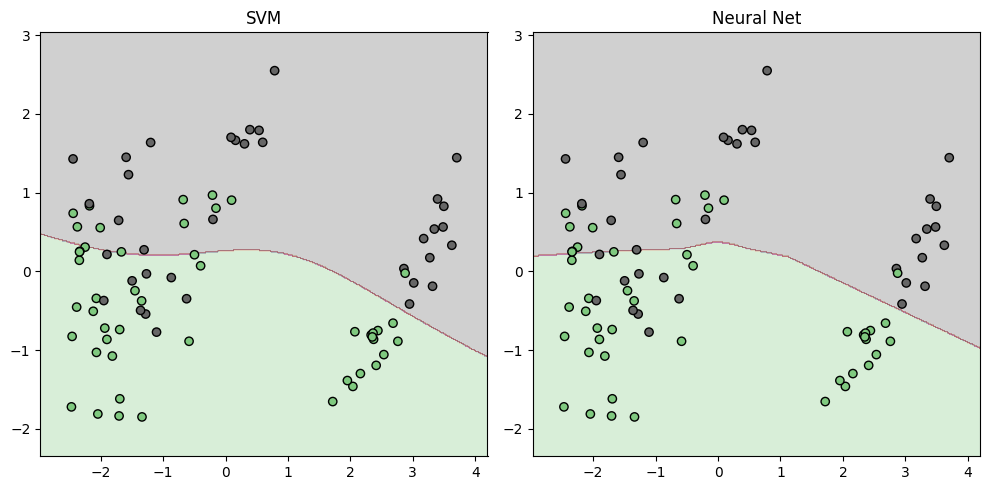

In [53]:
compare = ModelCompare([svc, neural_net])

compare.plot(X_test, y_test, titles=['SVM', 'Neural Net'])